# アドバンスドビジョンレポート
## Cannyエッジ検出の実装

本レポートでは、OpenCVの画像処理ライブラリを使用せずにゼロから実装するものである。
### ライブラリの読み込み

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as m_img

### 写真の読み込みと表示

image shape: (540, 960, 3)


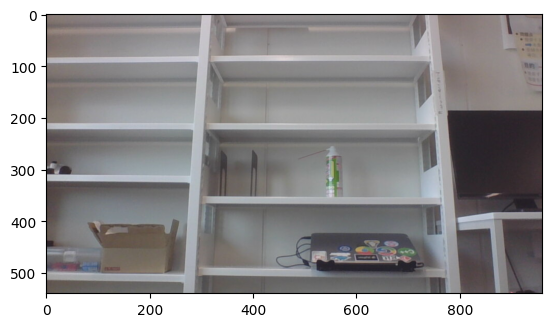

In [2]:
image = m_img.imread('background.jpg')

plt.imshow(image)
print('image shape:', image.shape)

### RGB画像をグレースケール化

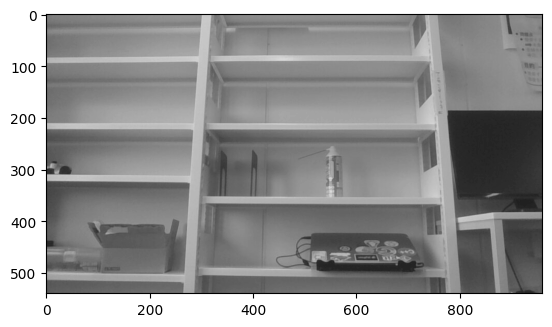

In [3]:
img_height, img_width, _ = image.shape
gray_image = np.zeros((img_height, img_width))

red_image = image[:,:,0]
green_image = image[:,:,1]
blue_image = image[:,:,2]

gray_image = (red_image*0.299) + (green_image*0.587) + (blue_image*0.114)

plt.imshow(gray_image, cmap='gray', vmin=0.0, vmax=255.0)

### 5x5ガウシアンフィルタで写真のノイズを除去

In [4]:
def generate_gaussian_kernel(size, sigma):
    # floor計算: 5//2 == 2
    kernel_center = size//2
    
    # 行列のそれぞれの位置座標から中心点までの距離の行列
    # 列: 5x5の行列で、0行2列の要素から中心点3,3までの移動距離は
    #    それぞれ|0-3|,|2-3| -> sqrt(3**2 + 1**2)である
    #    この距離に応じてガウス分布の分布があれば、その点の重み(確率密度)
    #    を計算する事が出来る
    # mgridを使用すると、簡単にそれぞれ要素に当てはまる位置座標の行列を
    # 簡単に作成出来る
    distance_row, distance_col = np.mgrid[-kernel_center:kernel_center+1,
                                          -kernel_center:kernel_center+1]
    
    return (1/(2.0*np.pi*sigma**2)) * (np.exp(-(distance_row**2 + distance_col**2)/(2*sigma**2)))

In [18]:
# 手動で作るガウシアンフィルタは行列のそれぞれの
# 要素に好きな値を調整する事が可能で、
# ガウス分布のσ値をピッタリ中心点と行列の一番外に
# あるの要素の間にある要素に、相当する値を簡単に
# 代入出来る。
# 
# 自動生成はそれぞれの要素に自動で値を入れられるが、
# 行列の端にある要素にガウス分布の端の値が代入され
# るとは限らない。なぜなら、要素の間にある物理距離は
# 分布の値に直接反映されるからだ。

# 中心: 5x5の標準偏差σ=10.3のガウシアンフィルタ
gausian_filter = (np.array([[1,4,7,4,1],
                           [4,16,26,16,4],
                           [7,26,41,26,7],
                           [4,16,26,16,4],
                           [1,4,7,4,1]]))/273

# サイズ5x5、σ=1.0のガウシアンフィルタを生成する
gausian_filter = generate_gaussian_kernel(5, 1)

print(gausian_filter)

[[0.00291502 0.01306423 0.02153928 0.01306423 0.00291502]
 [0.01306423 0.05854983 0.09653235 0.05854983 0.01306423]
 [0.02153928 0.09653235 0.15915494 0.09653235 0.02153928]
 [0.01306423 0.05854983 0.09653235 0.05854983 0.01306423]
 [0.00291502 0.01306423 0.02153928 0.01306423 0.00291502]]


(540, 960)


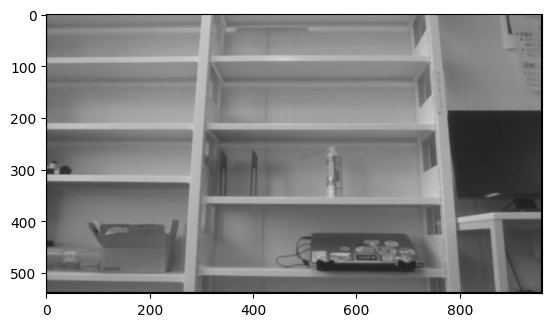

In [19]:
smooth_gray_image = np.zeros(gray_image.shape)

for h in range(2, img_height-2):
    for w in range(2, img_width-2):
        smooth_gray_image[h, w] = (gray_image[h-2:h+3, w-2:w+3] * gausian_filter).sum()

print(smooth_gray_image.shape)
plt.imshow(smooth_gray_image, cmap='gray', vmin=0.0, vmax=255.0)

### Sobelフィルターで画像の縦と横軸をそれぞれ1次微分を行い、画像の輝度の勾配を計算する

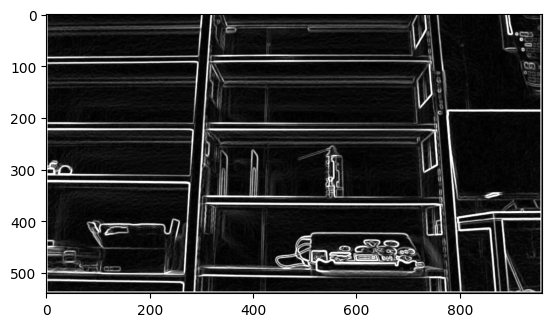

In [66]:
sobel_row = np.array([[-1, 0, 1],
                     [-2, 0, 2],
                     [-1, 0, 1]])
sobel_col = np.array([[-1, -2, -1],
                      [0, 0, 0],
                      [1, 2, 1]])

image_gradient_intensity = np.zeros(smooth_gray_image.shape)
image_gradient_angle = np.zeros(smooth_gray_image.shape)

for row in range(1, img_height-1, 1):
    for col in range(1, img_width-1, 1):
        gradient_row = (smooth_gray_image[row-1:row+2, col-1:col+2] * sobel_row).sum()
        gradient_col = (smooth_gray_image[row-1:row+2, col-1:col+2] * sobel_col).sum()
        
        image_gradient_intensity[row, col] = np.sqrt(gradient_row**2 + gradient_col**2)
        image_gradient_angle[row, col] = np.arctan2(gradient_col, gradient_row)
                
# 勾配の値をスケールする、大きな値がより大きくする
gradient_scale = 2
image_gradient_intensity *= gradient_scale
        
# 255を超えた値を255にする
image_gradient_intensity[(image_gradient_intensity > 255)] = 255

plt.imshow(image_gradient_intensity, cmap='gray', vmin=0.0, vmax=255.0)

### 非極大値の抑制

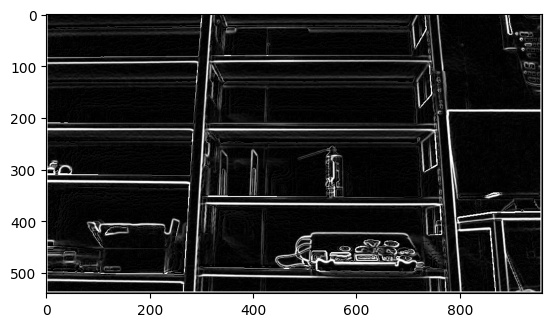

In [67]:
for row in range(1, img_height-1):
    for col in range(1, img_width-1):
        # 縦エッジ
        if (abs(image_gradient_angle[row, col]) <= np.radians(22.5)):
            if (image_gradient_intensity[row, col] < image_gradient_intensity[row, col-1]) or (image_gradient_intensity[row, col] < image_gradient_intensity[row, col+1]):
                image_gradient_intensity[row, col] = 0.0
        # 横エッジ
        elif np.radians(67.5) < image_gradient_angle[row, col] <= np.radians(112.5):
            if (image_gradient_intensity[row, col] < image_gradient_intensity[row-1, col]) or (image_gradient_intensity[row, col] < image_gradient_intensity[row+1, col]):
                image_gradient_intensity[row, col] = 0.0
        # 右斜め上と左斜め下エッジ
        elif (np.radians(22.5) < image_gradient_angle[row, col] <= np.radians(67.5)):
            if (image_gradient_intensity[row, col] < image_gradient_intensity[row-1, col-1]) or (image_gradient_intensity[row, col] < image_gradient_intensity[row+1, col+1]):
                image_gradient_intensity[row, col] = 0.0            
        # 右斜め下と左斜め上エッジ
        elif (np.radians(112.5) < image_gradient_angle[row, col] <= np.radians(157.5)):            
            if (image_gradient_intensity[row, col] < image_gradient_intensity[row-1, col+1]) or (image_gradient_intensity[row, col] < image_gradient_intensity[row+1, col-1]):
                image_gradient_intensity[row, col] = 0.0

#plt.imsave('non-maxima-supp.jpg', image_gradient_intensity)
plt.imshow(image_gradient_intensity, cmap='gray', vmin=0.0, vmax=255.0)

### ヒステリシスしきい値処理

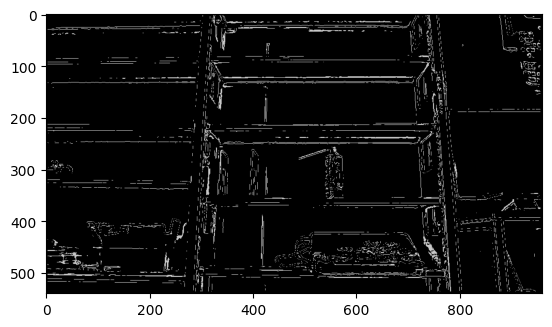

In [83]:
low_threshold = 50
high_threshold = 100

l_image = np.zeros(image_gradient_intensity.shape)
h_image = np.zeros(image_gradient_intensity.shape)
hys_image = np.zeros(image_gradient_intensity.shape)


# 弱いエッジの画像
mask = (image_gradient_intensity > low_threshold) & (image_gradient_intensity < high_threshold)
l_image = l_image + (200 * mask)

# 強いエッジの画像
mask = (image_gradient_intensity > high_threshold)
h_image = h_image + (255 * mask)

# 弱いエッジ
#plt.imsave('low-hysterasis.jpg', l_image)
plt.imshow(l_image, cmap='gray', vmin=0.0, vmax=255.0)

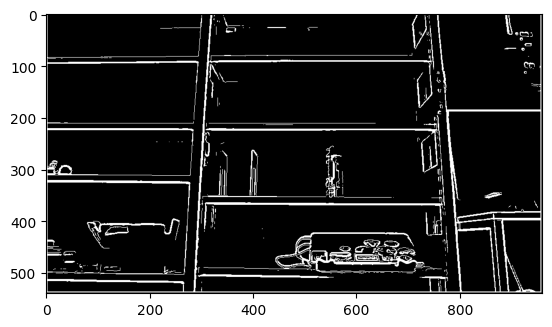

In [84]:
# 強いエッジ
#plt.imsave('high-hysterasis.jpg', h_image)
plt.imshow(h_image, cmap='gray', vmin=0.0, vmax=255.0)

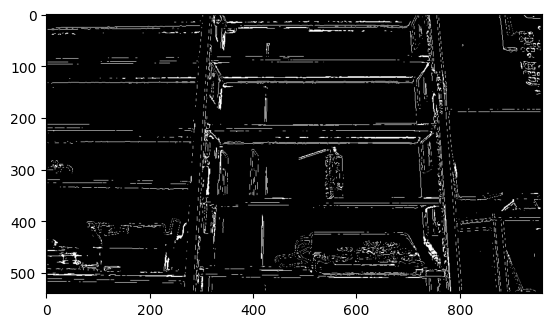

In [85]:
# ヒステリシスしきい値処理
# 強いエッジと繋がっている弱いエッジを強いエッジに変換する

# 既にある強いエッジである弱いエッジを削除
hys_l_image = l_image * (h_image != 255)
hys_l_image[hys_l_image > 0] = 255

plt.imshow(hys_l_image, cmap='gray', vmin=0.0, vmax=255.0)

In [ ]:
# 強いエッジと繋がっている画素を探し、追加する
connected_edges = []

# 強いエッジと繋がる弱いエッジを全部探すループ
while(connected_edges):
    

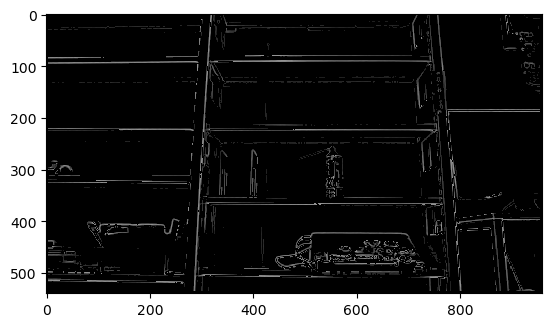

In [14]:
# ヒステリシスしきい値処理
for row in range(1, img_height-1, 1):
    for col in range(1, img_width-1, 1):
        if low_threshold < image_gradient_intensity[row, col] < high_threshold:
            hys_image[row, col] = image_gradient_intensity[row, col]

#plt.imsave('hysterasis.jpg', hys_image)
plt.imshow(hys_image, cmap='gray', vmin=0.0, vmax=255.0)

### OpenCVライブラリを用いたCannyエッジ検出との比較

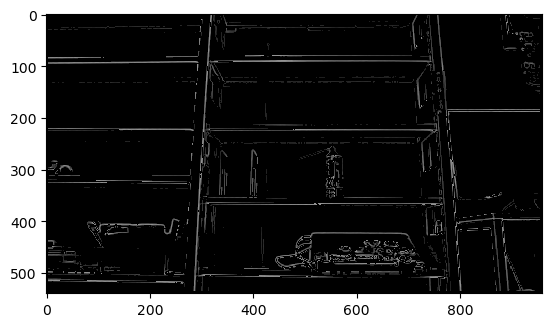

In [15]:
# 本レポートで実装したCannyエッジ検出画像            
plt.imshow(hys_image, cmap='gray', vmin=0.0, vmax=255.0)

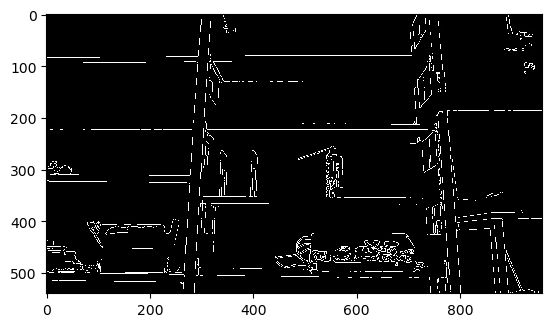

In [16]:
# OpenCVのCannyエッジ検出画像
opencv_image = m_img.imread('opencv_canny_edge.jpg')
plt.imshow(opencv_image, cmap='gray', vmin=0.0, vmax=255.0)